In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [3]:
class BasicBlock(nn.Module):
    """Basic residual block for ResNet18, ResNet34"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # First convolution
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            # Option B: Use 1x1 convolutions for dimension matching
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out

In [4]:
class CIFAR10_ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout_rate=0.3):
        super(CIFAR10_ResNet, self).__init__()
        self.in_channels = 32  # Start with 32 filters to reduce parameters
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, 
                              stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        # Stacked residual blocks
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 190, num_blocks[2], stride=2)
        
        # Final layers
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(190, num_classes)
        
        # Weight initialization
        self._initialize_weights()
        
    def _make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, channels, stride))
            self.in_channels = channels
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Initial layers
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Global average pooling and classification
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.linear(out)
        
        return out

In [5]:
# Build model with n=7 for a 44-layer network (as recommended)
def resnet44_cifar10():
    return CIFAR10_ResNet(BasicBlock, [7, 7, 7])


In [6]:
import pickle
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import os

# Function to load CIFAR-10 batch files
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load all CIFAR-10 training batches
def load_all_cifar_batches(directory):
    all_images = []
    all_labels = []
    for i in range(1, 6):
        batch = load_cifar_batch(os.path.join(directory, f'data_batch_{i}'))
        all_images.append(batch[b'data'])
        all_labels.extend(batch[b'labels'])
    all_images = np.vstack(all_images).reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
    return all_images, all_labels

# Custom dataset class
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        
        if self.transform:
            img = self.transform(img)
            
        if self.labels is not None:
            label = self.labels[idx]
            return img, label
        else:
            return img

def get_data_loaders(batch_size=64, num_workers=2, cifar10_dir='deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'):
    """Load CIFAR-10 data from files and create data loaders"""
    
    # Load the label names
    meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
    label_names = meta_data_dict[b'label_names']
    
    # Load all training data (data_batch_1 to data_batch_5)
    train_images, train_labels = load_all_cifar_batches(cifar10_dir)
    
    # Load test batch to use as validation set
    test_batch = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
    val_images = test_batch[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)
    val_labels = test_batch[b'labels']

    # Normalize the images
    train_images = train_images / 255.0
    val_images = val_images / 255.0

    # # Split training data into training and validation sets
    # train_images, val_images, train_labels, val_labels = train_test_split(
    #     train_images, train_labels, test_size=0.1, random_state=42
    # )

    # Define data augmentation for training
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # Define transforms for validation and test
    val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])

    # test_transform = transforms.Compose([
    #     transforms.ToPILImage(),
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    # ])

    # Create datasets
    train_dataset = CustomCIFAR10Dataset(train_images, train_labels, transform=train_transform)
    val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=val_transform)
    # test_dataset = CustomCIFAR10Dataset(test_images, test_labels, transform=test_transform)

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    # test_loader = DataLoader(
    #     test_dataset, 
    #     batch_size=batch_size, 
    #     shuffle=False,
    #     num_workers=num_workers,
    #     pin_memory=True
    # )
    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(train_images[i])
        plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
        plt.axis('off')
    plt.show()

    plt.figure(figsize=(20, 4))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(val_images[i])
        plt.title(label_names[val_labels[i]].decode('utf-8'))  # Decoding from bytes to string
        plt.axis('off')
    plt.show()
    return train_loader, val_loader, label_names


In [7]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

In [8]:
def validate(model, val_loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

In [9]:
def train_model(model, train_loader, val_loader, epochs=200, lr=0.1, 
                momentum=0.9, weight_decay=1e-4, lr_milestones=None):
    """Train model with learning rate schedule"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Move model to device
    model.to(device)
    
    # Count parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {num_params:,}")
    
    # Create loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, 
                           momentum=momentum, weight_decay=weight_decay)
    
    # Learning rate scheduler
    if lr_milestones is None:
        lr_milestones = [100, 150]  # Default milestones
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                               milestones=lr_milestones, 
                                               gamma=0.1)
    
    # Training loop
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                           optimizer, device)
        
        # Validation (using val_loader instead of test_loader)
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update scheduler
        scheduler.step()
        
        # Save statistics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'resnet_cifar10_best.pth')
        
        # Print progress
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch: {epoch+1}/{epochs} | '
                  f'Train Loss: {train_loss:.4f} | '
                  f'Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss:.4f} | '
                  f'Val Acc: {val_acc:.2f}% | '
                  f'LR: {scheduler.get_last_lr()[0]:.6f}')
    
    # Training time
    total_time = time.time() - start_time
    print(f'Training completed in {total_time/60:.2f} minutes')
    print(f'Best validation accuracy: {best_acc:.2f}%')
    
    # Plot training history
    plot_training_history(history)
    
    return history, best_acc


In [10]:
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    
    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Accuracy Curves')
    
    plt.tight_layout()
    plt.savefig('resnet_cifar10_training.png')
    plt.show()

In [11]:

# Create model
model = resnet44_cifar10()



In [12]:
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Use a string for the device parameter
summary(model, (3, 32, 32), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 32, 32, 32]           9,216
      BatchNorm2d-14           [-1, 32,

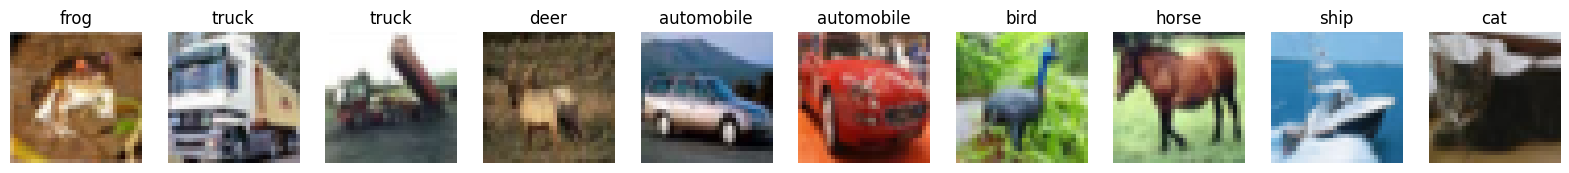

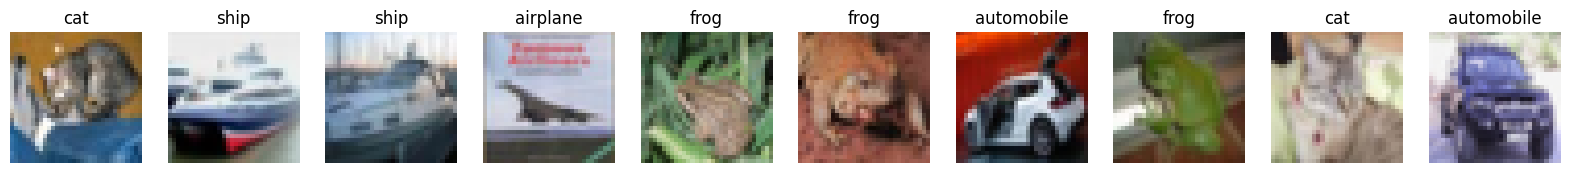

Using device: cuda
Number of trainable parameters: 4,985,390
Epoch: 1/200 | Train Loss: 2.6154 | Train Acc: 18.42% | Val Loss: 1.8926 | Val Acc: 29.00% | LR: 0.100000
Epoch: 11/200 | Train Loss: 0.7275 | Train Acc: 75.09% | Val Loss: 0.7018 | Val Acc: 76.67% | LR: 0.100000
Epoch: 21/200 | Train Loss: 0.4851 | Train Acc: 83.62% | Val Loss: 0.5559 | Val Acc: 82.21% | LR: 0.100000
Epoch: 31/200 | Train Loss: 0.4043 | Train Acc: 86.23% | Val Loss: 0.3833 | Val Acc: 87.20% | LR: 0.100000
Epoch: 41/200 | Train Loss: 0.3583 | Train Acc: 87.94% | Val Loss: 0.4916 | Val Acc: 85.29% | LR: 0.100000
Epoch: 51/200 | Train Loss: 0.3266 | Train Acc: 88.74% | Val Loss: 0.3284 | Val Acc: 89.12% | LR: 0.100000
Epoch: 61/200 | Train Loss: 0.3094 | Train Acc: 89.51% | Val Loss: 0.3492 | Val Acc: 89.40% | LR: 0.100000
Epoch: 71/200 | Train Loss: 0.3004 | Train Acc: 89.62% | Val Loss: 0.3793 | Val Acc: 87.88% | LR: 0.100000
Epoch: 81/200 | Train Loss: 0.1625 | Train Acc: 94.53% | Val Loss: 0.1981 | Val Acc:

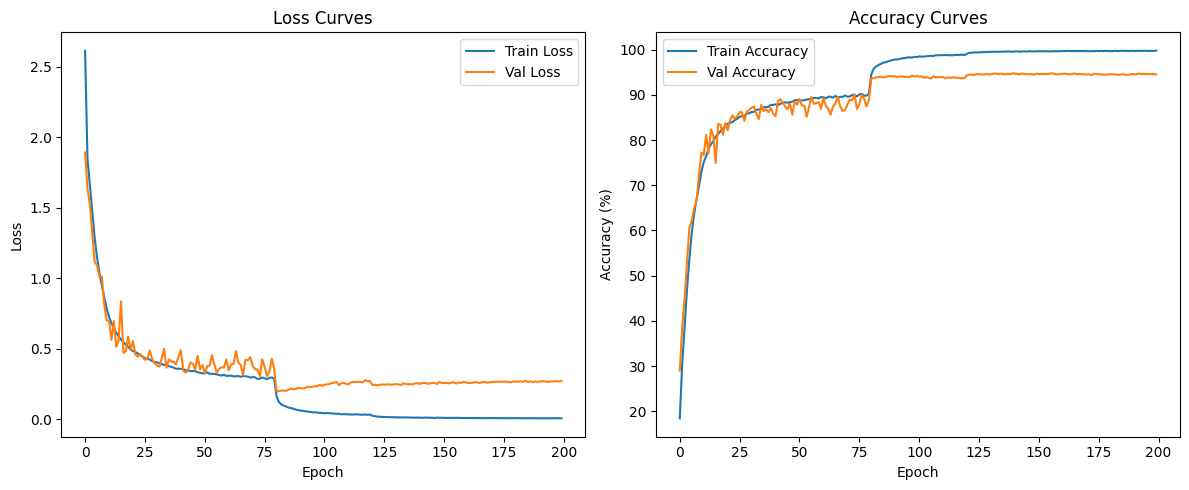

Training completed!


In [13]:

# Get data loaders
train_loader, val_loader, label_names = get_data_loaders(batch_size=64)

# Train model
history, best_acc = train_model(
    model, 
    train_loader, 
    val_loader,  # Use val_loader instead of test_loader for validation
    epochs=200,
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-4,
    lr_milestones=[80, 120]
)

print("Training completed!")

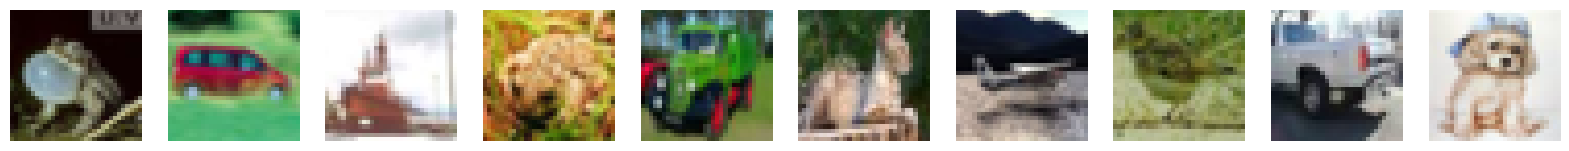

In [14]:
##SUBMISSION PART

import pandas as pd
import pickle
import torch
import numpy as np

# Load the test data without labels for submission
test_file = 'deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'  # Fixed path

with open(test_file, 'rb') as f:
    test_data = pickle.load(f, encoding='bytes')

# Extract test images from the dictionary
test_images = test_data[b'data']

# Reshape and normalize test images
if len(test_images.shape) == 2:
    test_images = test_images.reshape((-1, 3, 32, 32)).transpose(0, 2, 3, 1)
else:
    test_images = test_images  # Already in (32, 32, 3)
test_images = test_images / 255.0

# Define test transforms
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


# In[5]:


# Visualize the first 10 test images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')
plt.show()


# In[7]:


# Modified dataset class for competition test data
class CompetitionTestDataset(torch.utils.data.Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img  # Only return images, no labels

# Create competition test dataset and loader
submission_dataset = CompetitionTestDataset(test_images, transform=test_transform)
submission_loader = DataLoader(
    submission_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Load your best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet44_cifar10()
model.load_state_dict(torch.load('resnet_cifar10_best.pth'))  # Make sure this is your best model
model = model.to(device)
model.eval()

# Generate predictions with test-time augmentation
predictions = []
with torch.no_grad():
    for images in submission_loader:
        images = images.to(device)
        
        # Apply TTA
        outputs = model(images)
        flipped = torch.flip(images, dims=[3])
        flipped_outputs = model(flipped)
        
        # Average predictions
        combined = (outputs + flipped_outputs) / 2
        _, predicted = combined.max(1)
        
        predictions.extend(predicted.cpu().numpy())

In [15]:
# Create and save submission file
submission = pd.DataFrame({
    'ID': range(len(predictions)),
    'Labels': predictions
})
submission.to_csv('submission83512.csv', index=False)
print(f"Submission created with {len(predictions)} predictions")

Submission created with 10000 predictions
